## **Preprocesamiento y análisis exploratorio de datos clínicos**

En este notebook se lleva a cabo el **preprocesamiento** y **análisis exploratorio de datos clínicos** con el fin de preparar un conjunto de datos para el entrenamiento de modelos de clasificación orientados a la predicción del **riesgo de diabetes**. Se incluyen tareas de **limpieza, transformación de variables, ingeniería de características** y **análisis de distribuciones, asegurando la consistencia clínica** y estadística de la información antes de la etapa de modelado.




### **Acerca del conjunto de datos**
Este conjunto de datos fue construido a partir de información pública de la Encuesta Nacional de Salud y Nutrición (ENSANUT) 2024, publicada por el Instituto Nacional de Salud Pública (INSP) de México:
https://ensanut.insp.mx/encuestas/ensanutcontinua2024/descargas.php

Para su elaboración se integraron y depuraron variables provenientes de distintos módulos de ENSANUT 2024, principalmente aquellos relacionados con antropometría y determinaciones bioquímicas para enfermedades crónicas.

El dataset final contiene información sociodemográfica, antropométrica y bioquímica de individuos en México. Entre las variables incluidas se encuentran identificadores de encuesta, sexo, edad, ciudad de residencia, peso, estatura, índice de masa corporal (IMC), ácido úrico, albúmina, creatinina, colesterol total, colesterol HDL y LDL, triglicéridos, glucosa sérica, insulina y hemoglobina glucosilada (HbA1c), así como variables de diseño muestral (ponderadores y estratos).


La columna final, riesgo_diabetes_cat, es una variable categórica creada a partir de criterios clínicos de la American Diabetes Association (ADA), que clasifica a los individuos en tres niveles de riesgo de desarrollar diabetes mellitus tipo 2:

0: Bajo o sin riesgo
1: Riesgo moderado (asociado a sobrepeso u obesidad sin alteración glucémica)
2: Riesgo alto (presencia de alteración glucémica compatible con criterios de prediabetes)




## **Preprocesamiento de los datos**




In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import warnings

In [ ]:
warnings.filterwarnings('ignore')

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/dataset/Diabetes_Mexico.csv')

In [ ]:
df.head()

,folio_i,folio_int,sexo,edad,Ciudad,Peso,Estatura,imc,muestra_suero,ac_urico,...,creat,glu_suero,insulina,trig,hb1ac,ponde_venosa,estrato,est_sel,ponde_hemo,riesgo_diabetes_cat
0,2024_01001010,2024_01001010_01,Mujer,89.0,AGUASCALIENTES,NaN,NaN,NaN,1.0,"4,1",...,"0,62",166.0,"4,7",107.0,NaN,"2245,917738",3.0,13.0,"2888,530238",2
1,2024_01001012,2024_01001012_01,Mujer,71.0,AGUASCALIENTES,NaN,NaN,32.0,1.0,"4,3",...,"0,64",98.0,"9,6",132.0,NaN,"2245,917738",3.0,13.0,"2888,530238",1
2,2024_01001016,2024_01001016_02,Mujer,57.0,AGUASCALIENTES,"80,25","170,6",NaN,1.0,"4,9",...,"0,6",128.0,"4,7",263.0,6.0,"4047,445276",3.0,13.0,NaN,2
3,2024_01001016,2024_01001016_05,Mujer,20.0,AGUASCALIENTES,"68,6","166,2",NaN,1.0,"4,9",...,"0,63",112.0,"10,1",238.0,NaN,"13079,14232",3.0,13.0,"13776,80526",2
4,2024_01001031,2024_01001031_01,Hombre,74.0,AGUASCALIENTES,NaN,NaN,NaN,1.0,"6,4",...,"1,09",97.0,"10,2",135.0,NaN,"5292,158204",3.0,13.0,"5824,779445",0


In [ ]:
df = df.drop(columns = ['folio_int','folio_i','Ciudad'])

Eliminamos nuestras variables que no son variables que nos ayuden para estimar el riesgo de daibetes.

In [ ]:
df.isnull() \
.mean() \
.sort_values(ascending=False) \
.to_frame(name="escala_nulos")

,escala_nulos
imc,0.986269
hb1ac,0.905453
ponde_hemo,0.384464
Estatura,0.282464
Peso,0.282464
ponde_venosa,0.038839
edad,0.009808
sexo,0.000000
muestra_suero,0.000000
col_ldl,0.000000


Con el fin de evaluar la calidad del conjunto de datos, se calculó el porcentaje de valores faltantes de cada variable, normalizado en un rango de 0 a 1. Este análisis permitió identificar variables con altos niveles de datos perdidos y definir estrategias adecuadas para su tratamiento o exclusión del modelo predictivo.

La variable **índice de masa corporal (IMC)** presentó un **porcentaje de valores faltantes cercano al 98 %**, lo cual limita severamente su uso directo. Este comportamiento se explica debido a que el IMC no se encontraba disponible originalmente para la mayoría de los registros. No obstante, dado que se cuenta con las variables peso y estatura, es posible **recalcular el IMC** para aquellos casos con información completa, permitiendo su incorporación posterior como una variable antropométrica clínicamente relevante.

La **hemoglobina glucosilada (HbA1c)** es una variable de **alta importancia** clínica, ya que refleja el nivel promedio de glucosa en sangre durante los últimos tres meses y constituye un indicador estándar para el diagnóstico y control de la diabetes. Sin embargo, esta variable presentó **aproximadamente un 90 % de valores faltantes**, lo que hace que cualquier proceso de imputación resulte estadística y clínicamente riesgoso. Por esta razón, se decidió excluirla del modelo predictivo principal, evitando la introducción de sesgos y valores artificiales que pudieran comprometer la validez del análisis.

El **ponderador de muestra de hemoglobina** presentó alrededor de un **40 % de valores faltantes.** Esta variable no corresponde a una medición clínica del individuo, sino a un peso estadístico asociado al diseño muestral de la encuesta, cuyo objetivo es ajustar la representatividad poblacional de la muestra. Dado que no aporta información fisiológica ni clínica relacionada con el riesgo de diabetes, y que su inclusión podría introducir sesgos asociados al proceso de muestreo, se decidió no considerarla como variable predictora del modelo.

Las variables **peso** y **estatura** mostraron **aproximadamente un 28 % de valores faltantes**. Dado que se trata de variables continuas con significado clínico y que **permiten el cálculo del IMC**, los valores faltantes fueron imputados utilizando la **mediana**, una medida robusta frente a valores extremos. Posteriormente, estas variables fueron utilizadas para calcular el IMC, y se excluyeron del conjunto final de variables predictoras para evitar redundancia y multicolinealidad.

Por otro lado, el **ponderador de muestra venosa** presentó menos del **1 % de valores faltantes**, los cuales podrían ser imputados mediante la mediana sin afectar significativamente la distribución de la variable. Sin embargo, al igual que otros ponderadores, esta variable corresponde al diseño muestral y no representa una característica clínica del individuo. Por ello, se evaluó su relevancia y se concluyó que no aporta información significativa al modelo predictivo, dado el conjunto de variables clínicas seleccionadas.



In [ ]:
df.drop(columns=['imc','hb1ac','ponde_hemo','ponde_venosa'], inplace=True)

In [ ]:
df.select_dtypes(include='object').columns

Index(['sexo', 'Peso', 'Estatura', 'ac_urico', 'albu', 'col_hdl', 'creat',
       'insulina'],
      dtype='object')

In [ ]:
def object_to_float(x):
  df[x] = df[x].str.replace(',', '.').astype(float)
  return df[x]

In [ ]:
columns = ['Peso', 'Estatura', 'ac_urico', 'albu','col_hdl', 'creat','insulina']

for column in columns:
  df[column] = object_to_float(column)

Antes de realizar cualquier tratamiento de valores nulos o aplicar técnicas de modelado, fue necesario llevar a cabo un proceso de **limpieza de datos**. Este consistió en eliminar las comas de los valores y convertir las columnas correspondientes a un **tipo numérico adecuado**. Este paso resulta fundamental para garantizar la correcta interpretación de las variables, permitir el cálculo de estadísticas descriptivas y asegurar un funcionamiento adecuado de los algoritmos de aprendizaje automático.

In [ ]:
def nan_to_median(x):
  df[x] = df[x].replace(np.nan,df[x].median())
  return df[x]

In [ ]:
columns = ['Peso','Estatura','edad']

for column in columns:
  df[column] = nan_to_median(column)

Los valores nulos fueron reemplazados utilizando la **mediana** de cada variable, debido a que esta medida de tendencia central es menos sensible a la presencia de valores atípicos y distribuciones asimétricas, características comunes en datos clínicos y biométricos. Este enfoque permite conservar la estructura estadística de los datos y reducir el impacto de observaciones extremas en el proceso de modelado.

## **Ingeniería de características**

In [ ]:
df["imc"] = df['Peso'] / ((df['Estatura'] / 100) ** 2)

Como parte del proceso de **ingeniería de características**, se creó la variable **índice de masa corporal (IMC)** a partir de las variables peso y estatura, las cuales representan mediciones antropométricas fundamentales. A pesar de que el IMC presentaba un alto porcentaje de valores faltantes en su forma original, fue posible recuperar esta variable mediante su recalculo, dado que se contaba con información de peso y estatura para una proporción significativa de los registros.

El IMC se calculó utilizando la fórmula estándar (peso en kilogramos dividido entre la estatura en metros al cuadrado), lo que permitió incorporar al modelo una variable clínicamente relevante y ampliamente utilizada en la evaluación del riesgo metabólico y de diabetes. Posteriormente, las variables peso y estatura fueron excluidas del conjunto final de características para evitar redundancia y multicolinealidad, conservando el IMC como el principal indicador antropométrico.

### **Selección de variables**

In [ ]:
cols = ['sexo','edad','imc','glu_suero','trig','col_hdl','insulina','ac_urico','riesgo_diabetes_cat']
df = df[cols]

Las variables relacionadas con el diseño muestral y ponderadores fueron excluidas del modelo predictivo, dado que no representan características clínicas del individuo y podrían introducir sesgos en la predicción del riesgo de diabetes.

## **Análisis Exploratorio**

In [ ]:
import math

In [ ]:
sns.set_style('whitegrid')

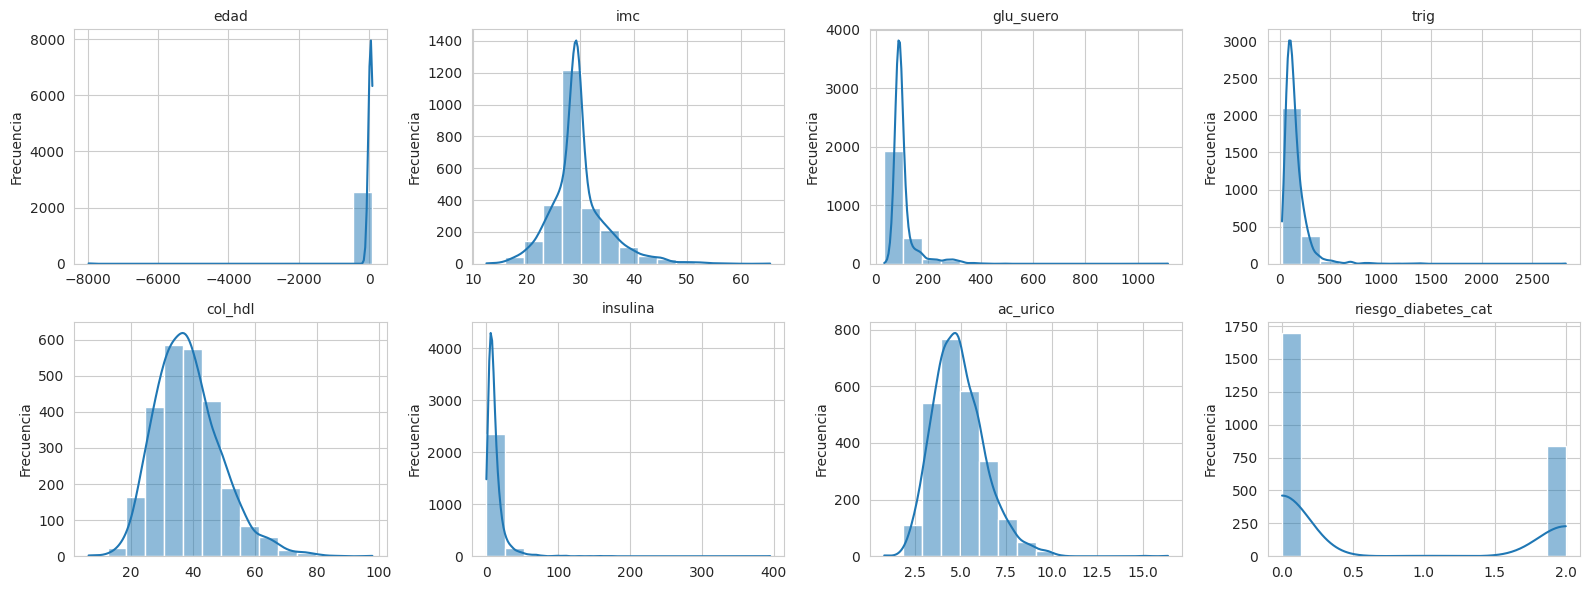

In [ ]:
cols = df.select_dtypes(include='number').columns


n_vars = len(cols)
n_cols = 4
n_rows = math.ceil(n_vars / n_cols)


fig, axes = plt.subplots(n_rows, n_cols, figsize=(16, n_rows * 3))
axes = axes.flatten()


for i, col in enumerate(cols):
    sns.histplot(
        data=df,
        x=col,
        bins=15,
        kde=True,
        ax=axes[i]
    )
    axes[i].set_title(f'{col}', fontsize=10)
    axes[i].set_xlabel('')
    axes[i].set_ylabel('Frecuencia')


for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

In [ ]:
df.edad.min()

-7975.0

In [ ]:
df[df.edad<=18]

,sexo,edad,imc,glu_suero,trig,col_hdl,insulina,ac_urico,riesgo_diabetes_cat
244,Hombre,-7975.0,32.612612,71.0,86.0,25.0,6.7,6.0,0
1155,Hombre,-7975.0,31.745710,135.0,246.0,36.0,17.4,5.2,2
1277,Mujer,-7975.0,23.281899,86.0,58.0,49.0,5.3,5.0,0
2388,Mujer,-7975.0,29.245633,86.0,103.0,22.0,6.9,4.3,0


In [ ]:
df = df[df.edad>=18]

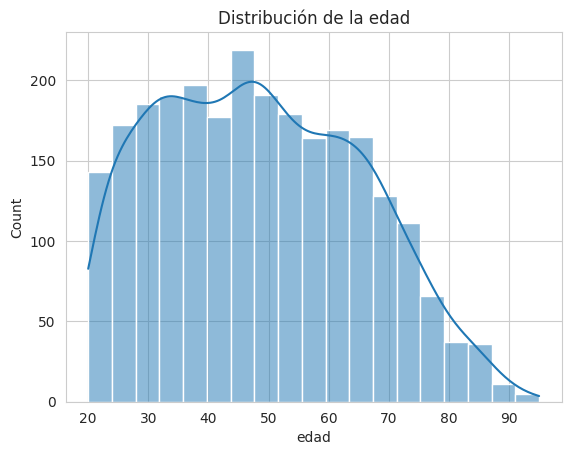

In [ ]:
plt.title('Distribución de la edad')
sns.histplot(data = df,x = "edad",kde = True)
plt.show()

A partir del análisis exploratorio de los datos, se observó que varias variables continuas presentan distribuciones asimétricas y colas pronunciadas, lo cual es común en datos clínicos. Por esta razón, se plantea la aplicación de una **transformación de potencia (PowerTransformer)** como parte del proceso de preprocesamiento, con el objetivo de reducir la asimetría de las distribuciones y mejorar la estabilidad numérica del modelo.

Esta transformación será especialmente relevante para **modelos sensibles a la escala** y a la **distribución de las variables**, tales como la **regresión logística, máquinas de soporte vectorial (SVM), k vecinos más cercanos (k-NN)** y **redes neuronales**, en los cuales la magnitud y forma de las variables influyen directamente en el proceso de aprendizaje.

Previamente a la aplicación de la transformación, se realizará una **limpieza de datos** para identificar y corregir valores clínicamente imposibles, como edades negativas, garantizando la coherencia y validez de la información. La transformación se aplicará únicamente a variables continuas con significado clínico, cuidando no afectar la interpretabilidad del modelo.

In [ ]:
mapa_riesgo = {
    0: 'Riesgo mínimo',
    1: 'Riesgo moderado',
    2: 'Riesgo muy alto'
}

df['riesgo_diabetes_label'] = df['riesgo_diabetes_cat'].map(mapa_riesgo)

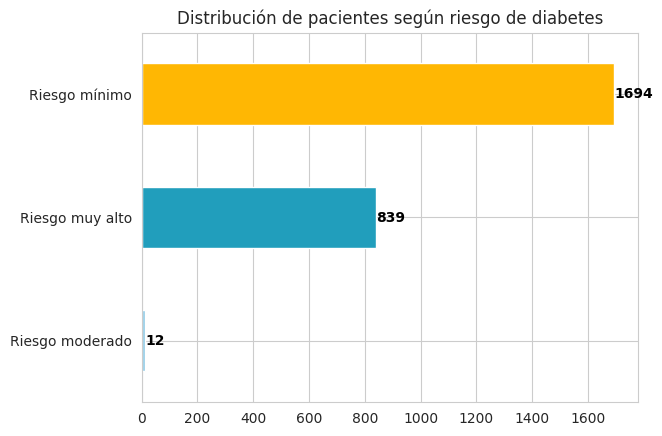

In [ ]:
counts = df['riesgo_diabetes_label'].value_counts(ascending=True)


ax = counts.plot(
    kind="barh",
    title="Distribución de pacientes según riesgo de diabetes",
    color=['#8ecae6', '#219ebc', '#ffb703']
)


plt.ylabel(None)


for i, v in enumerate(counts):
    ax.text(v + 0.5, i, str(v), color='black', va='center', fontweight='bold')

plt.show()

Durante la revisión del conjunto de datos se identificó que la clase “riesgo moderado” del target riesgo_diabetes_cat estaba representada por un número muy **reducido de observaciones (menos de 12 casos)**, lo que la convierte en una clase minoritaria extremadamente desbalanceada.

Dada la escasa representación de esta clase, el modelo podría aprender de manera ineficiente, generando predicciones inestables y **poco confiables** para el **riesgo moderado**. Por esta razón, se decidió eliminar la clase “moderado” solo dejando categorias como "bajo riesgo" y  “alto riesgo”,  lo que permite mantener la robustez del modelo y garantizar una predicción clínica más confiable.

Esta estrategia es metodológicamente defendible en problemas de clasificación con clases desbalanceadas y preserva la interpretación clínica, priorizando la identificación de individuos con riesgo elevado de diabetes.

In [ ]:
df = df[df.riesgo_diabetes_cat!=1]

In [ ]:
df.riesgo_diabetes_cat = np.where(df.riesgo_diabetes_cat==2,1,df.riesgo_diabetes_cat)
df.drop(columns=['riesgo_diabetes_label'],inplace = True)

In [ ]:
df.riesgo_diabetes_cat.value_counts()

,count
riesgo_diabetes_cat,
0,1694
1,839


In [ ]:
df.to_csv('/content/drive/MyDrive/dataset/Diabetes_Mexico_clean.csv',index=False)